In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

In [6]:
# import os
# import hashlib

# def remove_exact_duplicates(folder_path):
#     seen = set()
#     removed = 0

#     for subdir, _, files in os.walk(folder_path):
#         for file in files:
#             path = os.path.join(subdir, file)
#             try:
#                 with open(path, 'rb') as f:
#                     file_hash = hashlib.md5(f.read()).hexdigest()
#                 if file_hash in seen:
#                     os.remove(path)
#                     removed += 1
#                 else:
#                     seen.add(file_hash)
#             except Exception as e:
#                 print(f"Error processing {path}: {e}")

#     print(f"Removed {removed} exact duplicate image(s).")

# remove_exact_duplicates("helmet_dataset")


In [8]:
# --- SETTINGS ---
dataset_path = "helmet_dataset"
batch_size = 8
image_size = 224
epochs = 15
lr = 0.0003
print(os.listdir("helmet_dataset"))

['.DS_Store', 'not_looking', 'looking']


In [10]:
# --- DEVICE ---
if torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple M1/M2/M3/M4 GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [12]:
# --- SAFETY LOADER ---
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [14]:
# --- TRANSFORM ---
train_transform = transforms.Compose([
    transforms.Resize((320, 320)),              # Resize slightly bigger
    transforms.CenterCrop(300),                 # Crop to model input
    transforms.RandomHorizontalFlip(p=0.5),     # Good if left/right isn’t label-dependent
    transforms.RandomRotation(10),              # Small tilt variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


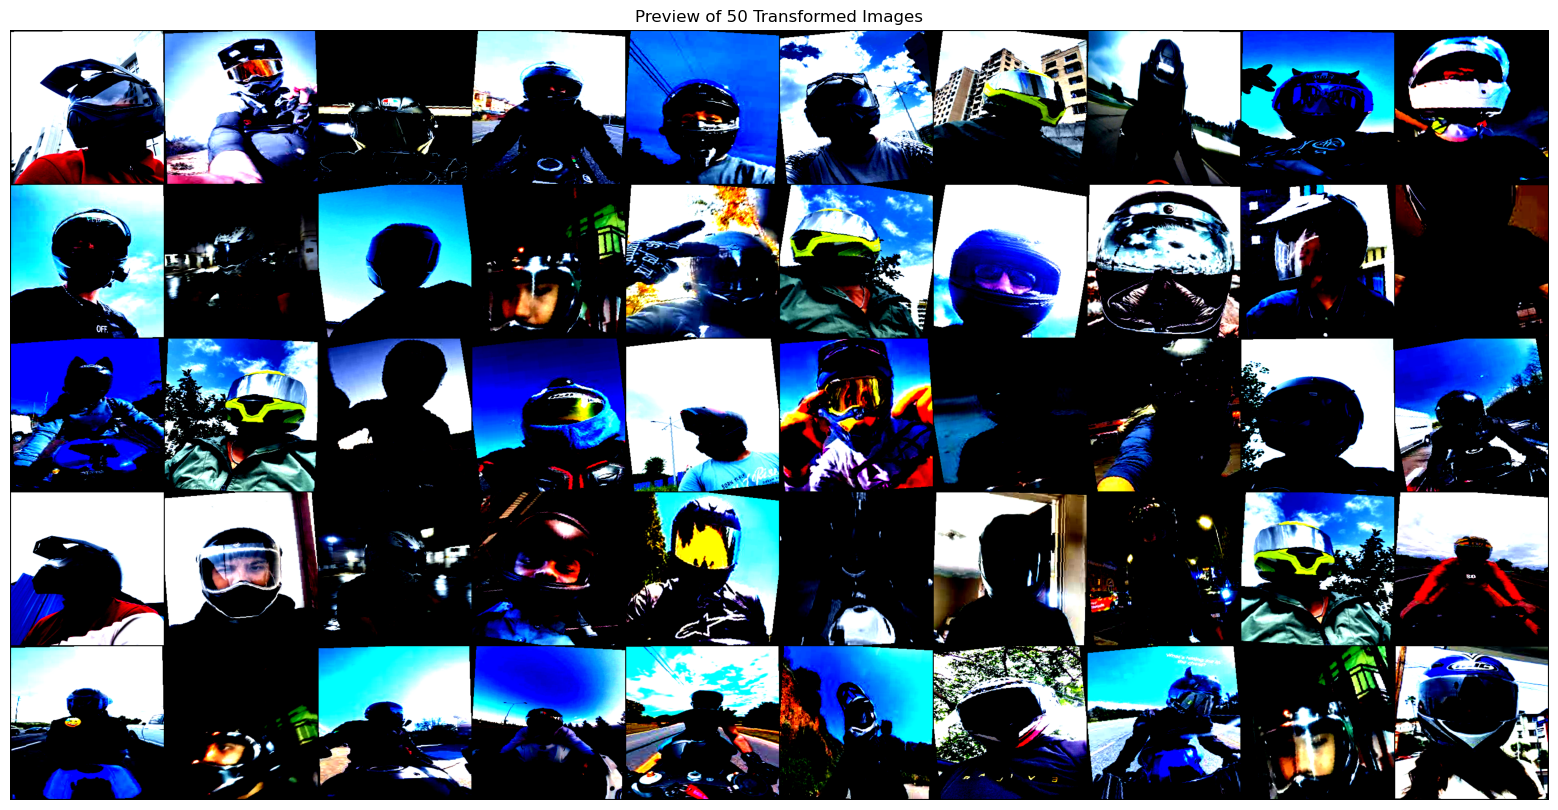

In [16]:
import torchvision

# Load dataset with transform applied
preview_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=train_transform,
    loader=pil_loader
)

# Create a DataLoader (no shuffling)
preview_loader = DataLoader(preview_dataset, batch_size=50, shuffle=True)

# Get one batch
images, labels = next(iter(preview_loader))

# Make a grid of 50 images (5 rows × 10 columns)
grid_img = torchvision.utils.make_grid(images[:50], nrow=10, padding=2)

# Unnormalize if needed (for display only)
np_img = grid_img.permute(1, 2, 0).numpy()

# Show the image grid
plt.figure(figsize=(20, 10))
plt.imshow(np_img)
plt.axis('off')
plt.title("Preview of 50 Transformed Images")
plt.show()

In [18]:
import shutil

# Delete any .ipynb_checkpoints inside helmet_dataset
checkpoints_path = os.path.join(dataset_path, ".ipynb_checkpoints")
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print("Removed .ipynb_checkpoints folder.")

In [20]:
# --- DATASET ---
def is_valid_image(path):
    return not any(x in path for x in ['.DS_Store', '.ipynb_checkpoints'])
    
dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=None,
    loader=pil_loader,
    is_valid_file=is_valid_image
)

print("Classes:", dataset.classes)
print("Class-to-index:", dataset.class_to_idx)

Classes: ['looking', 'not_looking']
Class-to-index: {'looking': 0, 'not_looking': 1}


In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# Use full dataset (700 images)
targets = dataset.targets  # From ImageFolder

# Change test_size here: 0.2 = 80/20 split, 0.3 = 70/30 split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Optional: Verify class balance
print("Train set size:", len(train_dataset))
print("Val set size:", len(val_dataset))

train_labels = [dataset.targets[i] for i in train_dataset.indices]
val_labels = [dataset.targets[i] for i in val_dataset.indices]
print("Train class counts:", Counter(train_labels))
print("Val class counts:", Counter(val_labels))

Train set size: 492
Val set size: 212
Train class counts: Counter({0: 247, 1: 245})
Val class counts: Counter({0: 106, 1: 106})


In [24]:
# Custom wrapper to apply transform after subset
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

# Apply transforms
train_dataset = TransformedSubset(train_dataset, train_transform)
val_dataset = TransformedSubset(val_dataset, val_transform)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
from torchvision.models import efficientnet_b3

model = efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # For binary classification
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# --- LOSS & OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [32]:
# --- METRICS TRACKING ---
train_losses = []
val_accuracies = []

In [ ]:
# --- TRAINING LOOP ---
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Accuracy: {accuracy:.2f}%")

Epoch 1/15 - Loss: 0.3907 - Val Accuracy: 92.45%
Epoch 2/15 - Loss: 0.2202 - Val Accuracy: 94.34%
Epoch 3/15 - Loss: 0.1376 - Val Accuracy: 92.45%
Epoch 4/15 - Loss: 0.1000 - Val Accuracy: 91.98%
Epoch 5/15 - Loss: 0.0618 - Val Accuracy: 92.92%
Epoch 6/15 - Loss: 0.0322 - Val Accuracy: 95.28%
Epoch 7/15 - Loss: 0.0585 - Val Accuracy: 91.51%
Epoch 8/15 - Loss: 0.0721 - Val Accuracy: 93.40%
Epoch 9/15 - Loss: 0.0846 - Val Accuracy: 93.87%
Epoch 10/15 - Loss: 0.0333 - Val Accuracy: 94.81%
Epoch 11/15 - Loss: 0.0549 - Val Accuracy: 93.40%
Epoch 12/15 - Loss: 0.0151 - Val Accuracy: 94.34%


In [ ]:
# --- FINAL REPORT ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

In [ ]:
# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# --- PLOTS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='red')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "efficientnet_b3_final.pth")